In [1]:
import os, sys
sys.path.insert(0, os.path.join(os.getcwd(), "src"))

In [5]:
import torch
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

def plot_posterior(data: ArrayLike, step: int, s_fixed, a_min, a_max):
    samples = load_step_samples(data, step)
    x, mean, lo, hi = q_posterior_band(samples, s_fixed, a_min=a_min, a_max=a_max, n_grid=201)

    plt.figure()
    plt.plot(x, mean, label="mean")
    plt.fill_between(x, lo, hi, alpha=0.25, label="90% CI")
    plt.xlabel("action a")
    plt.ylabel(f"Q({s_fixed}, a)")
    plt.title(f"{s_fixed} - step {step}")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_sigma(data: ArrayLike):
    step = [obs["step"] for obs in data]
    sigma = np.array([obs["samples"]["sigma"] for obs in data])

    plt.figure()
    plt.plot(step, sigma.mean(axis=1), label="sigma")
    plt.xlabel("step")
    plt.ylabel("sigma")
    plt.title("Sigma over time")
    plt.legend()
    plt.tight_layout()
    plt.show()

def q_posterior_band(samples: dict, s_fixed, a_min=-2.0, a_max=2.0, n_grid=201, qlo=0.05, qhi=0.95):
    # First layer: [S, in_dim, hidden]
    W1 = torch.as_tensor(samples["layer1_w"], dtype=torch.float32)   # e.g. [S, 5, 64]
    b1 = torch.as_tensor(samples["layer1_b"],   dtype=torch.float32)   # [S, 64]

    # Second layer: [S, hidden, 1]
    W2 = torch.as_tensor(samples["output_w"], dtype=torch.float32)   # [S, 64, 1]
    b2 = torch.as_tensor(samples["output_b"],   dtype=torch.float32)   # [S, 1]

    S, in_dim, hidden = W1.shape
    assert b1.shape == (S, hidden)
    assert W2.shape == (S, hidden, 1)
    assert b2.shape == (S, 1)

    state_dim = len(s_fixed)
    action_dim = in_dim - state_dim
    if action_dim < 1:
        raise ValueError(f"in_dim ({in_dim}) - len(s_fixed) ({state_dim}) < 1; check your state length vs. W1.")

    # Build input X = [s_fixed, a], sweeping only the first action coord
    a1 = torch.linspace(a_min, a_max, n_grid).unsqueeze(-1)   # [G, 1]
    if action_dim == 1:
        A = a1                                               # [G, 1]
    else:
        A = torch.zeros(n_grid, action_dim)
        A[:, 0] = a1[:, 0]                                   # vary first action dim; others 0

    s = torch.tensor(s_fixed, dtype=torch.float32).view(1, -1).expand(n_grid, -1)  # [G, state_dim]
    X = torch.cat([s, A], dim=-1)                            # [G, in_dim]

    # Forward with batched parameters (no loops)
    h = torch.einsum("gi,sio->sgo", X, W1) + b1[:, None, :]  # [S, G, hidden]
    h = torch.relu(h)
    q = torch.einsum("sgi,sio->sgo", h, W2) + b2[:, None, :] # [S, G, 1]
    q = q.squeeze(-1)                                        # [S, G]

    x = A[:, 0].cpu().numpy()
    mean = q.mean(dim=0).cpu().numpy()
    lo   = q.quantile(qlo, dim=0).cpu().numpy()
    hi   = q.quantile(qhi, dim=0).cpu().numpy()
    return x, mean, lo, hi

def load_step_samples(arr: ArrayLike, step: int):
    if step < 0:
        rec = arr[-1]
    else:
        rec = None
        for r in arr:
            it = r.item() if hasattr(r, "item") else r
            if int(it["step"]) == int(step):
                rec = it
                break
        if rec is None:
            raise ValueError(f"step {step} not found")
    samples = rec["samples"] if isinstance(rec, dict) else rec.item()["samples"]
    for k in ["layer1_w","layer1_b","output_w","output_b"]:
        if k not in samples:
            raise KeyError(f"missing '{k}' in samples (found: {list(samples.keys())})")
    return samples

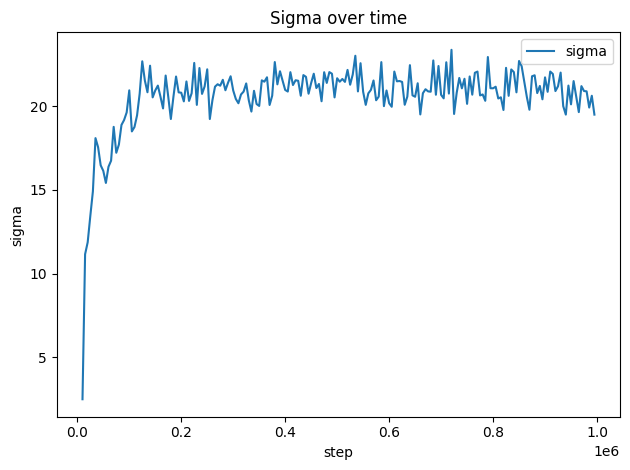

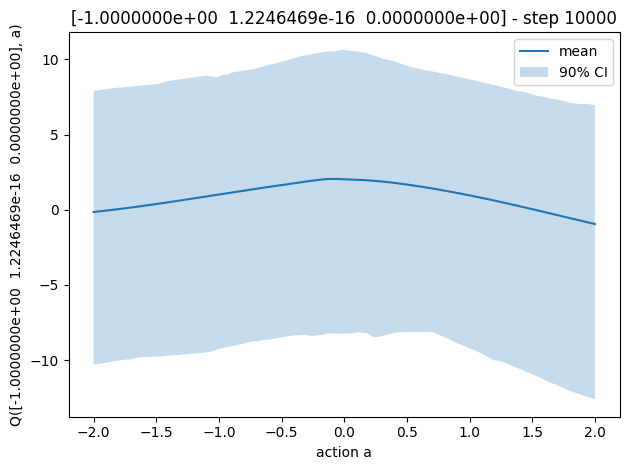

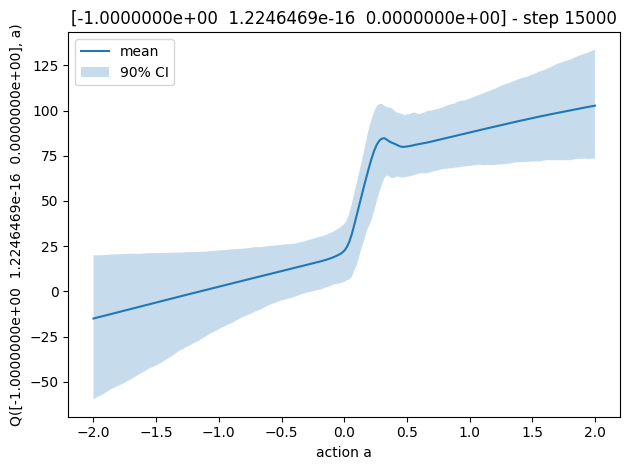

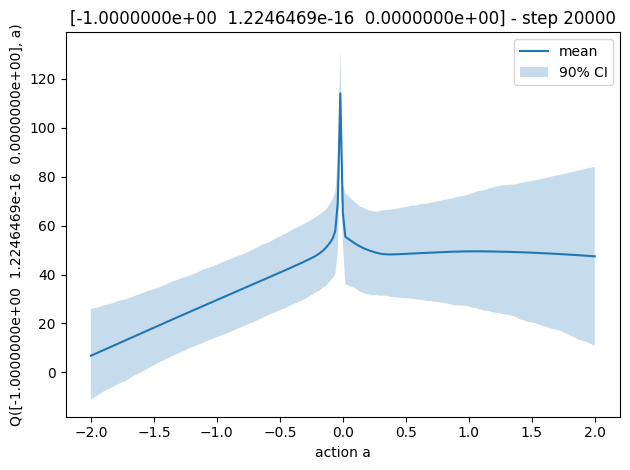

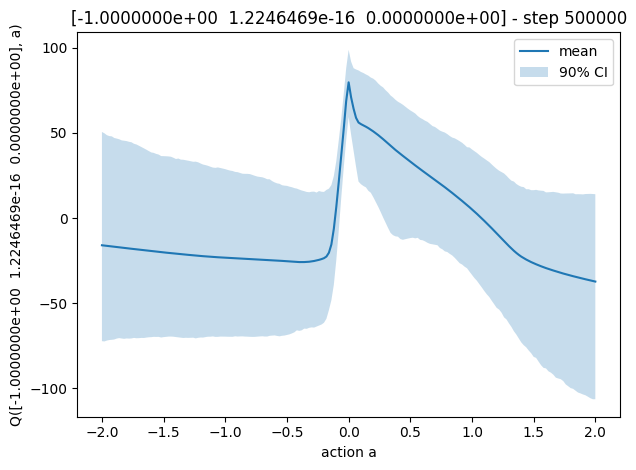

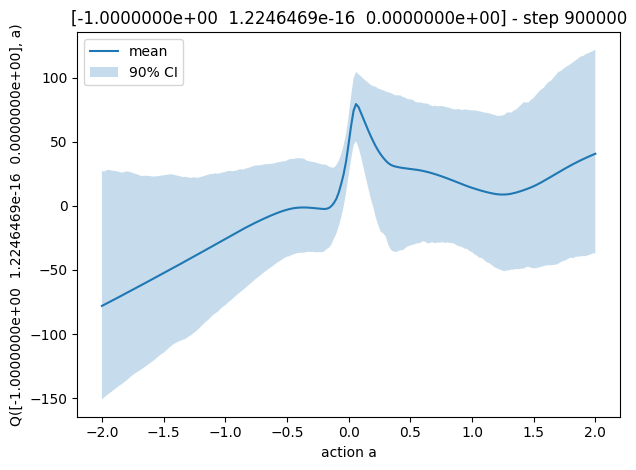

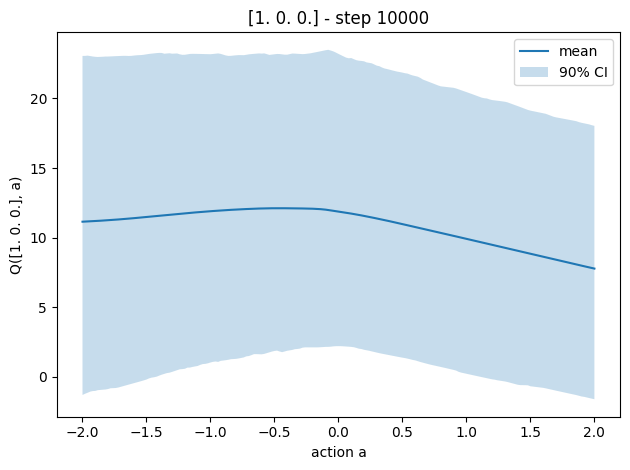

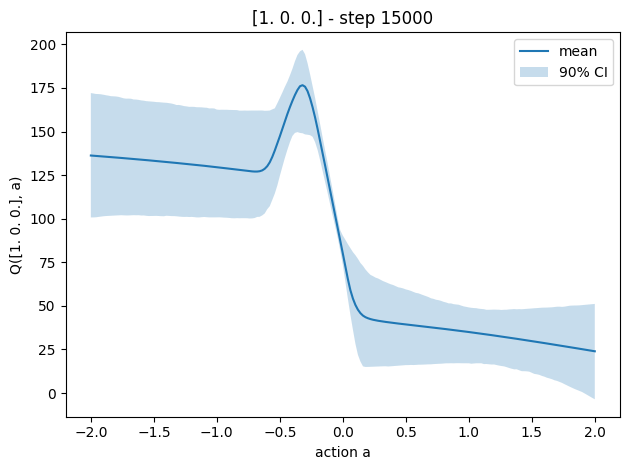

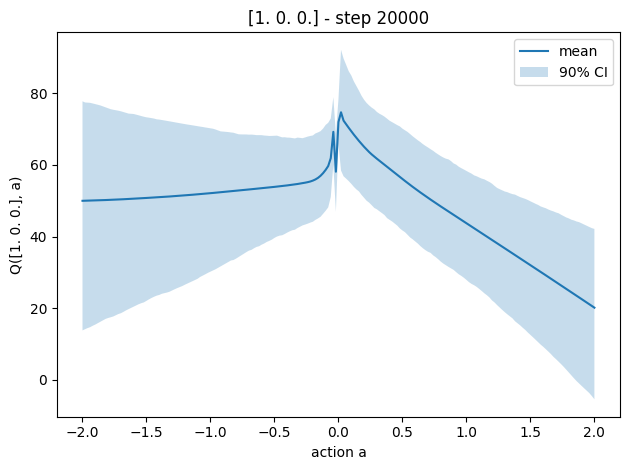

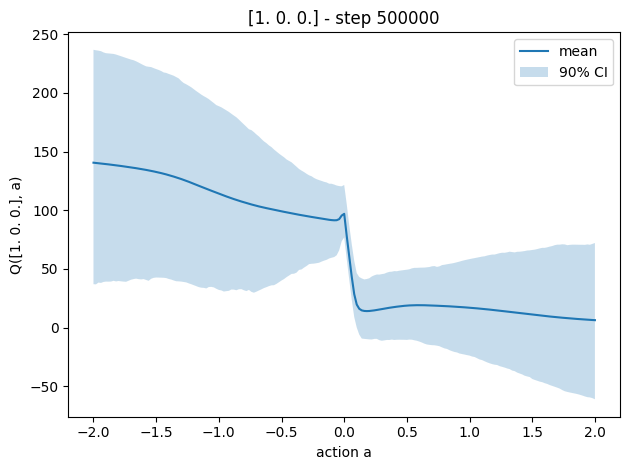

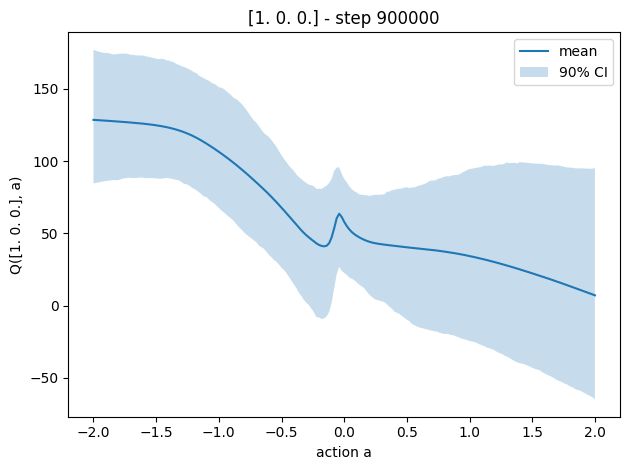

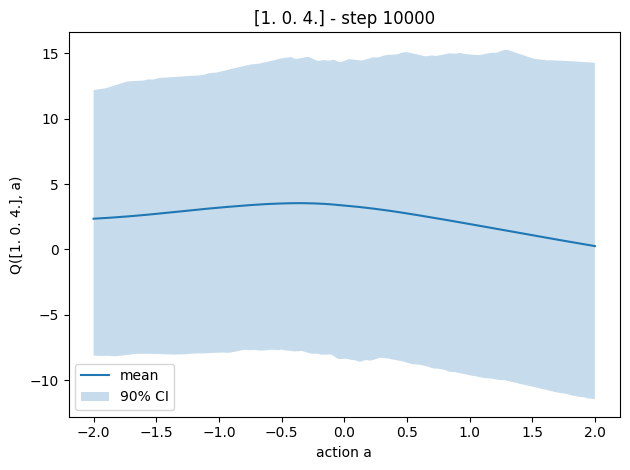

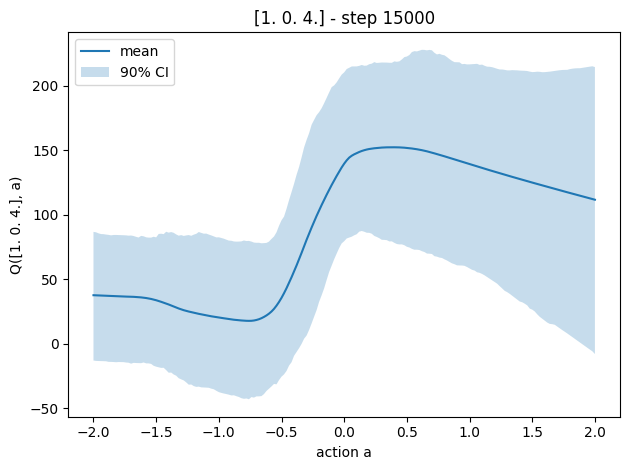

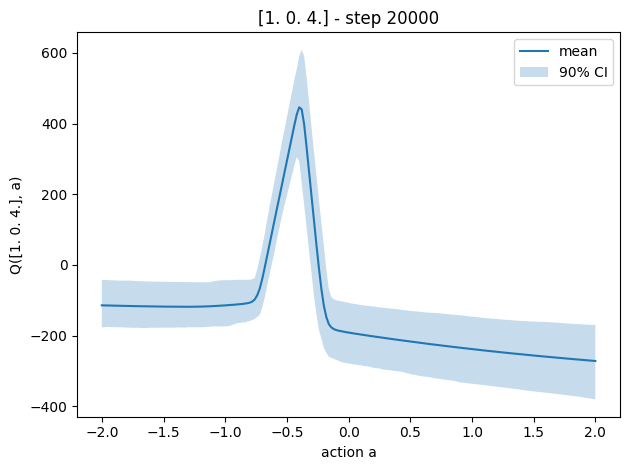

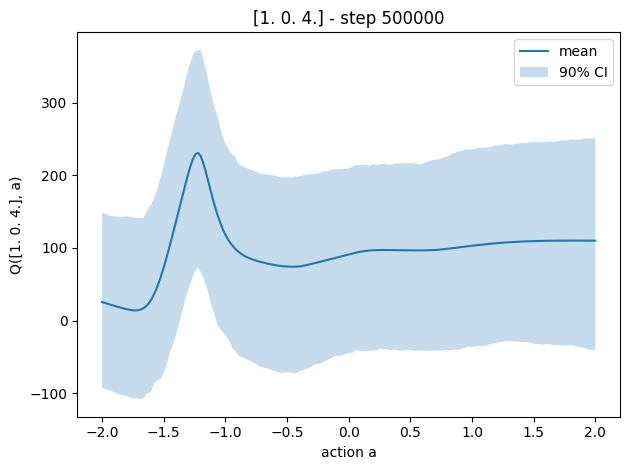

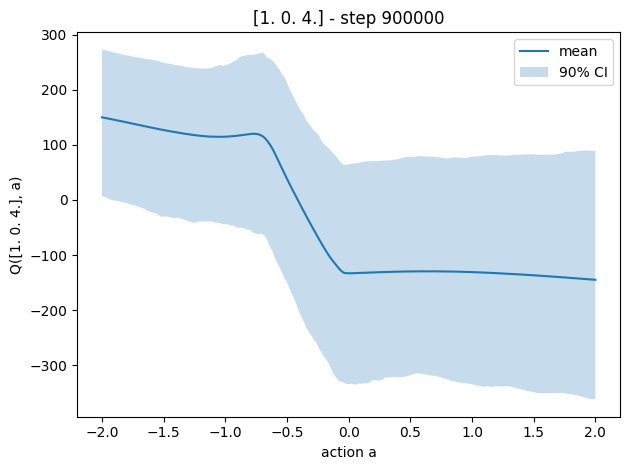

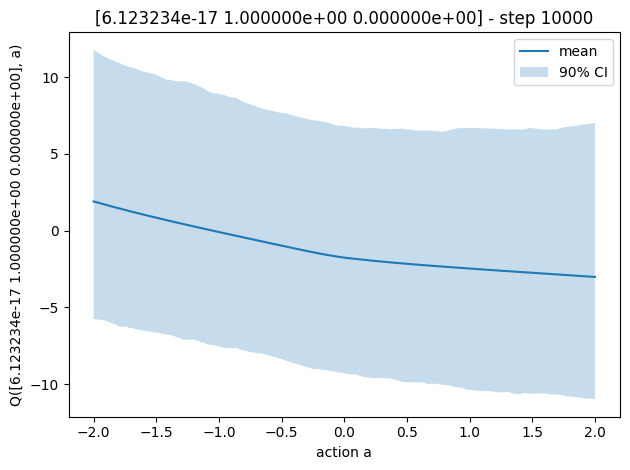

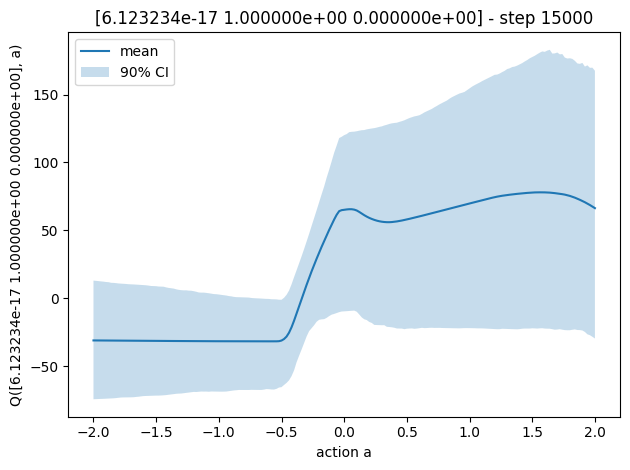

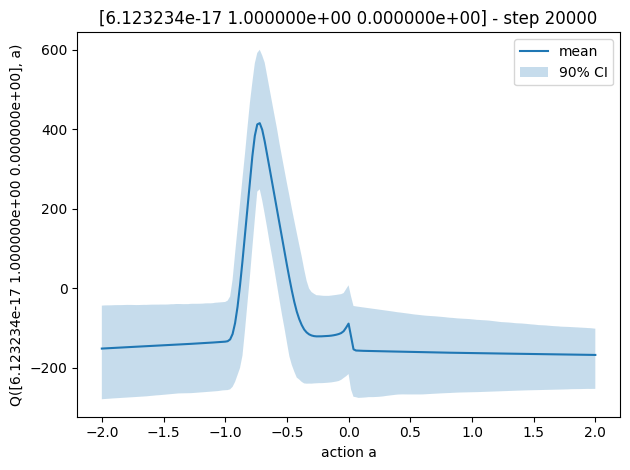

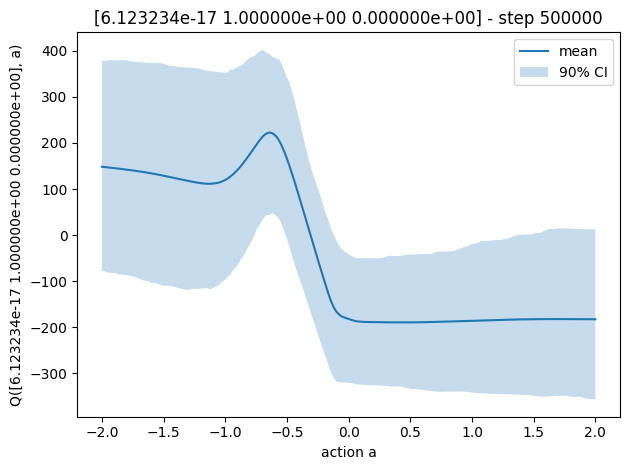

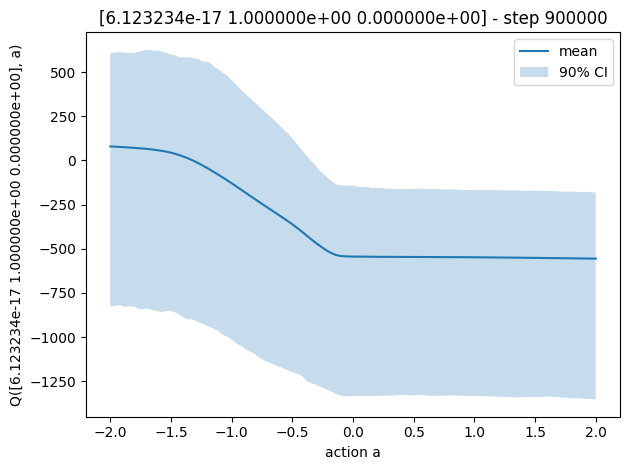

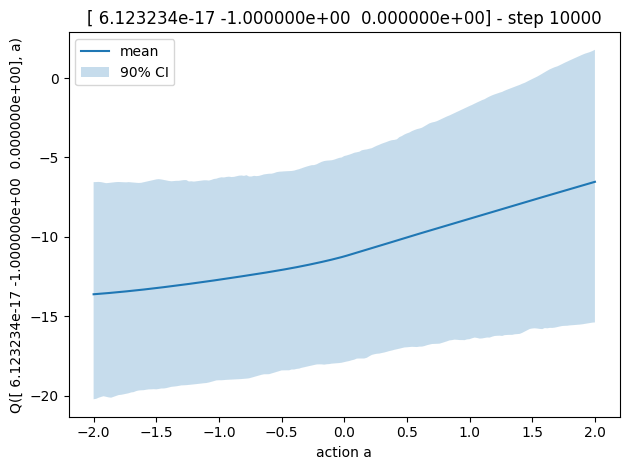

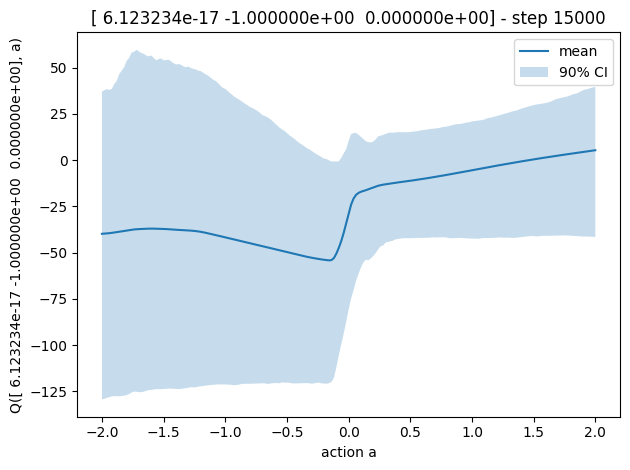

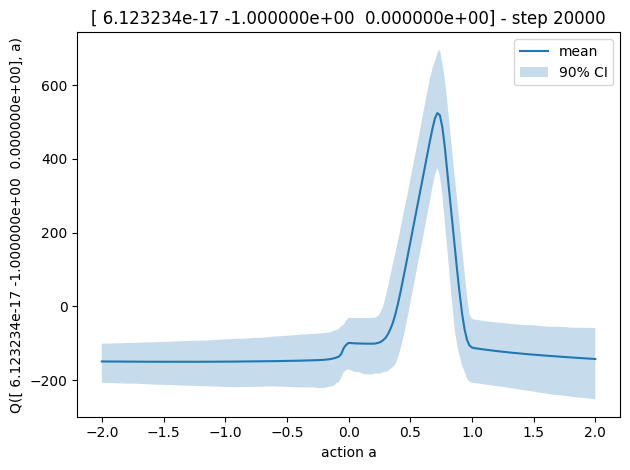

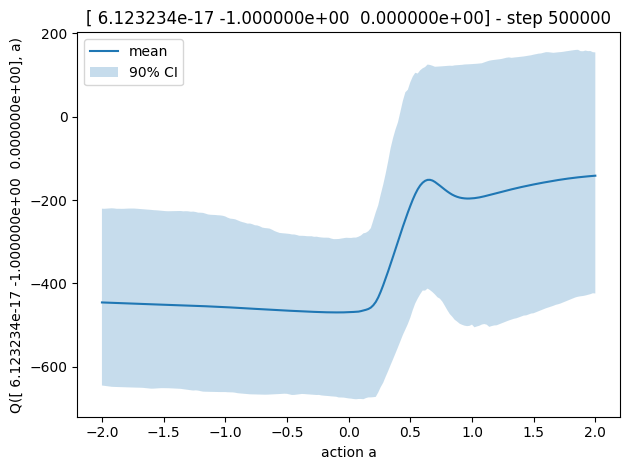

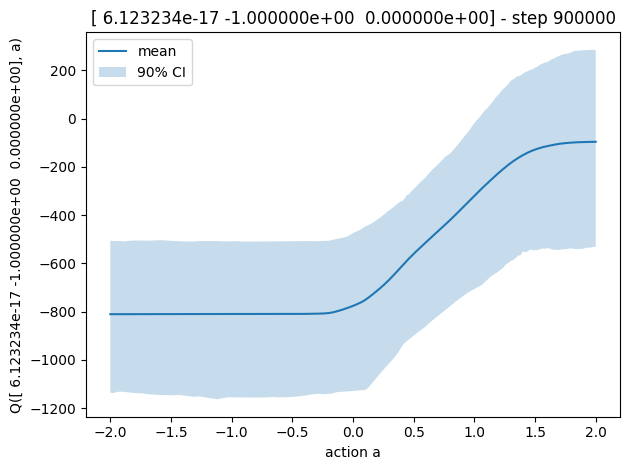

In [6]:
import numpy as np

from bac.util import load_from_npy

data = load_from_npy("./out/hmc_posterior_samples/ddpg_inverted_pendulum__hmc_large_100_5k_posterior_samples.npy")

plot_sigma(data)

def s_from(theta, theta_dot):
    return np.array([np.cos(theta), np.sin(theta), theta_dot], dtype=np.float32)

s_bottom      = s_from(np.pi, 0.0)       # [-1, 0, 0]
s_upright     = s_from(0.0, 0.0)         # [ 1, 0, 0]
s_upright_fast= s_from(0.0, 4.0)         # [ 1, 0, 4]
s_left_horiz  = s_from(+np.pi/2, 0.0)    # [ 0, 1, 0]
s_right_horiz = s_from(-np.pi/2, 0.0)    # [ 0,-1, 0]

states = [s_bottom, s_upright, s_upright_fast, s_left_horiz, s_right_horiz]

steps = [10_000, 15_000, 20_000, 500_000, 900_000]

for state in states:
    for step in steps:
        plot_posterior(data, step, state, a_min=-2.0, a_max=2.0)